# FYSS5403 Homework 5, Otto Salmenkivi

## Excercise 1 Quantum Teleportation

Let's start by setting up the register. We need a quantum register of 3 qubits. q0 will hold the state that will be teleported from Alice to Bob. q1 and q2 will be entangled in the Bell state $|\Phi\rangle = \frac{1}{\sqrt{2}}(|00\rangle+|11\rangle)$, so that Alice has q1 and Bob has q2. We also need 2 classical bits to transfer information from Alice to Bob in a classical channel.  
  
Alice entangles her pair of the bell qubits with the qubit that has the state that will be teleported, and then measuress her qubits. Then Bob applies gates based on those measurements.

In [1]:
from qiskit import *
from qiskit.quantum_info import random_state
from qiskit.visualization import plot_bloch_multivector, plot_histogram
from qiskit.extensions import Initialize
from qiskit.tools.monitor import job_monitor

import numpy as np
IBMQ.load_account()


/Applications/anaconda3/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: The `random_state` function is deprecated as of 0.13.0, and will be removed no earlier than 3 months after that release date. You should use the `random_statevector` function instead.
  


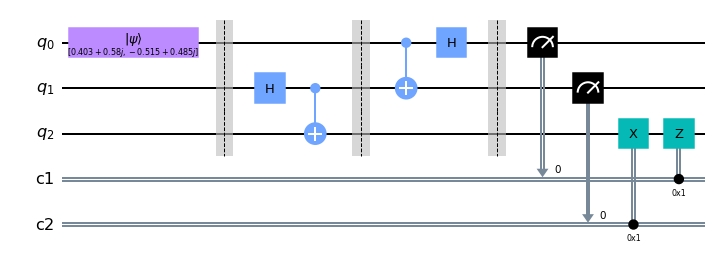

In [2]:
# setting up the circuit
qreg = QuantumRegister(3, name = "q")
creg1 = ClassicalRegister(1, name = "c1")
creg2 = ClassicalRegister(1, name = "c2")
qc = QuantumCircuit(qreg,creg1, creg2)

# intitializing the random state that will be teleported
state = random_state(2)
init_gate = Initialize(state)
qc.append(init_gate, [0])
qc.barrier()

# creating the Bell state for q1 and q2
qc.h(1)
qc.cx(1,2)
qc.barrier()

# Alice entagles q1 and the q0 (the one that will be teleported)
qc.cx(0,1)
qc.h(0)
qc.barrier()

# and then measures both of her gates
qc.measure([0,1],[0,1])

# Bob's conditional gates

qc.x(2).c_if(creg2,1)
qc.z(2).c_if(creg1,1)

qc.draw(output = 'mpl')

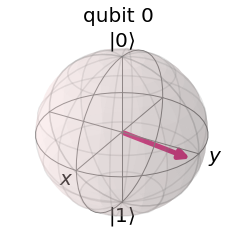

In [3]:
# the random state before teloportation in q0
plot_bloch_multivector(state)

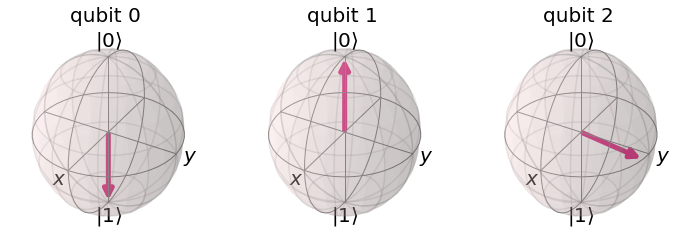

In [4]:
# running the circuit in simulator
statevector_simulator = Aer.get_backend('statevector_simulator')
out_vector = execute(qc, backend = statevector_simulator).result().get_statevector()
plot_bloch_multivector(out_vector)

We can see that the random state has teleported form q0 to q2, in other words from Alice to Bob. No-cloning theorem is still statisfied, because Alice's state collapsed in measurement.  
  
We can modify the circuit to have no measurents and conditional gates.

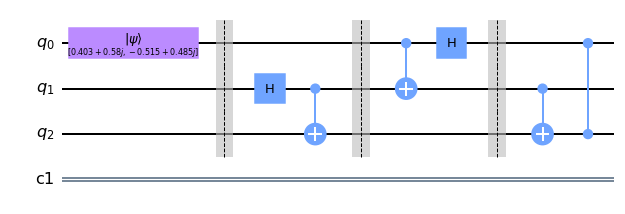

In [5]:
# Circuit without measurents and conditional gates.
qc = QuantumCircuit(qreg,creg1)

# intitializing the random state that will be teleported
qc.initialize(state,0)
qc.barrier()

# creating the Bell state for q1 and q2
qc.h(1)
qc.cx(1,2)
qc.barrier()

# Alice entagles q1 and the q0 (the one that will be teleported)
qc.cx(0,1)
qc.h(0)
qc.barrier()

# Bob's gates
qc.cx(1,2)
qc.cz(0,2)

qc.draw(output = 'mpl')

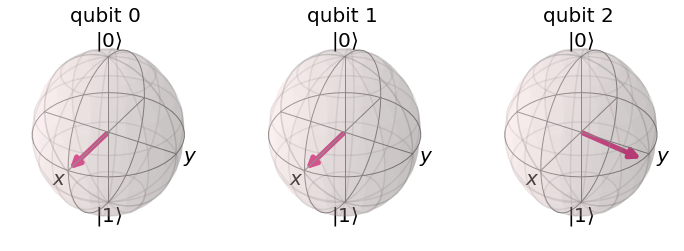

In [6]:
# running the circuit in simulator
out_vector = execute(qc, backend = statevector_simulator).result().get_statevector()
plot_bloch_multivector(out_vector)

Like in Qiskit textbook, we can check the results on quantum hardware, but in order to do this the circuit needs a small addition. Measuring the teleported state would give little information, but if we apply the inverse of the initialization to the state at the end, we should measure state 0 with high probability.

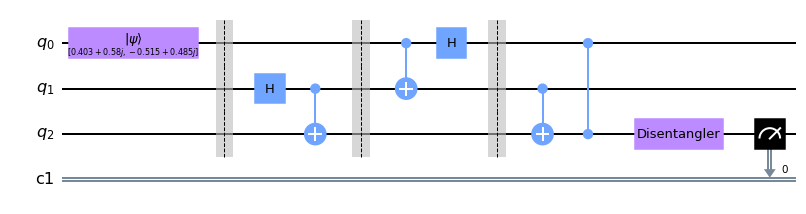

In [7]:
# addition of the inverse of initialization to the end
inv_init_gate = init_gate.gates_to_uncompute()
qc.append(inv_init_gate,[2])
qc.measure(2,0)
qc.draw(output = 'mpl')

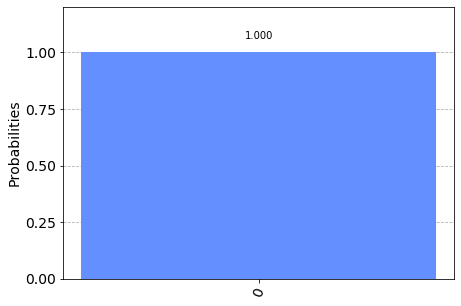

In [8]:
# running the circuit in simulation
simulator = Aer.get_backend('qasm_simulator')
job = execute(qc,backend = simulator)
counts = job.result().get_counts()
plot_histogram(counts)

In [9]:
# running the circuit in quantum computer
provider = IBMQ.get_provider('ibm-q')
from qiskit.providers.ibmq import least_busy

small_devices = provider.backends(filters=lambda x: x.configuration().n_qubits == 5
                                   and not x.configuration().simulator)
qcomp = least_busy(small_devices)
print('The backend used is',qcomp)

The backend used is ibmqx2


In [10]:
qcomp_job = execute(qc,backend = qcomp)
job_monitor(qcomp_job)
qcomp_counts = qcomp_job.result().get_counts()

Job Status: job has successfully run


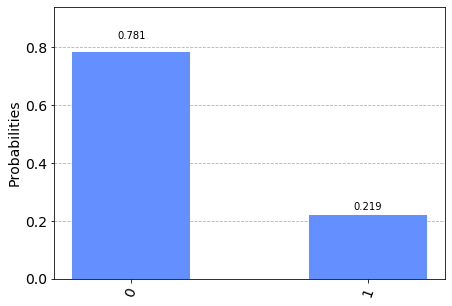

In [11]:
plot_histogram(qcomp_counts)

As we can see, the results show high probability for measuring q2 in state 0. Thus, the teleportation has worked.

## Excercise 2 Bell’s inequality




In [20]:
# Function to build the circuit for each E(a,b)
def E_circuit(a,b):
    circuit = QuantumCircuit(2,2)
    # initialize bell state
    circuit.h(0)
    circuit.cx(0,1)
    # rotations before measurement
    if a != 0: circuit.rz(a,0)
    if b != 0: circuit.rz(b,1)
    circuit.barrier()
    circuit.measure([0,1],[0,1])
    return circuit

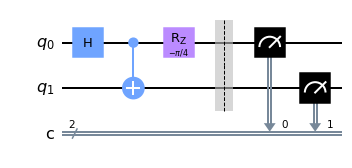

In [21]:
# Example of a E circuit, E(-pi/2, 0)
circuit_e1 = E_circuit(-np.pi/4,0)
circuit_e1.draw(output = 'mpl')

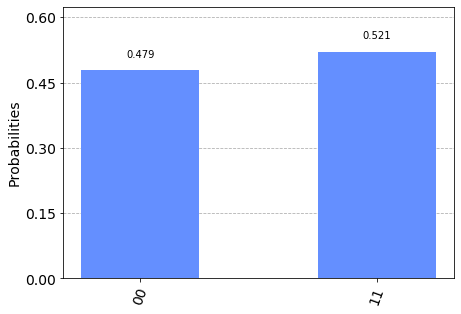

In [64]:
# equal shots for all circuits
shots = 1024
# histograms for each E(a,b)
counts_e1 = execute(circuit_e1, backend = simulator).result().get_counts()
plot_histogram(counts_e1)

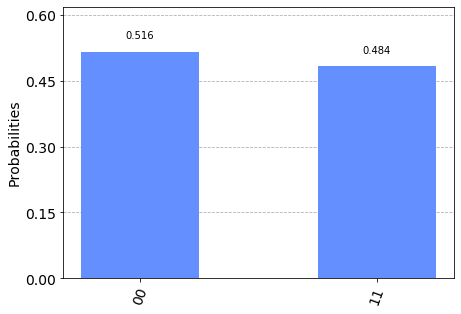

In [65]:
circuit_e2 = E_circuit(-np.pi/4,np.pi/2)
counts_e2 = execute(circuit_e2, backend = simulator).result().get_counts()
plot_histogram(counts_e2)

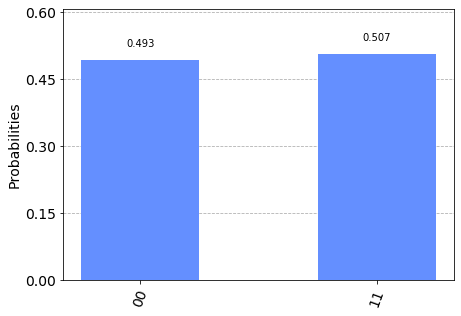

In [66]:
circuit_e3 = E_circuit(np.pi/4,0)
counts_e3 = execute(circuit_e3, backend = simulator).result().get_counts()
plot_histogram(counts_e3)

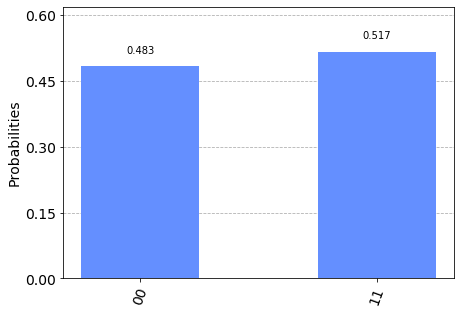

In [67]:
circuit_e4 = E_circuit(np.pi/4,np.pi/2)
counts_e4 = execute(circuit_e4, backend = simulator).result().get_counts()
plot_histogram(counts_e4)

In [87]:
# in simulation there are no hits for states 01 and 10
S =  (counts_e1.get('00') + counts_e1.get('11')
     - counts_e2.get('00') - counts_e2.get('11')
     + counts_e3.get('00') + counts_e3.get('11')
     + counts_e4.get('00') + counts_e4.get('11'))/ shots
print(S)

2.0


In [85]:
# general function for calculating S in qcomp
# a1: rotation for first measurement axis for qubit 0
# a2: rotation for second measurement axis for qubit 0
# b1: rotation for first measurement axis for qubit 1
# b2: rotation for second measurement axis for qubit 1

def calculate_S(a1, a2, b1, b2, backend):
    shots = 1024
    circuit_e1 = E_circuit(a1,b1)
    counts_e1 = execute(circuit_e1, backend = backend).result().get_counts()
    circuit_e2 = E_circuit(a1,b2)
    counts_e2 = execute(circuit_e2, backend = backend).result().get_counts()
    circuit_e3 = E_circuit(a2,b1)
    counts_e3 = execute(circuit_e3, backend = backend).result().get_counts()
    circuit_e4 = E_circuit(a2,b2)
    counts_e4 = execute(circuit_e4, backend = backend).result().get_counts()
        
    S = (counts_e1.get('00') + counts_e1.get('11')   - counts_e1.get('10') - counts_e1.get('01')
         - counts_e2.get('00') - counts_e2.get('11') + counts_e2.get('10') + counts_e2.get('01')
         + counts_e3.get('00') + counts_e3.get('11') - counts_e3.get('10') - counts_e3.get('01')
         + counts_e4.get('00') + counts_e4.get('11') - counts_e4.get('10') - counts_e4.get('01')
        )/shots
    return S

In [86]:
S1 = calculate_S(-np.pi/2,np.pi/4,0,np.pi/2,qcomp)
print(S1)

1.69921875


### Results
In simulation S = 2 was achieved. In real quantum computer S ≈ 1.7.